In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list
from desc.utils import cross
from desc.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
from desc.magnetic_fields._current_potential import solve_regularized_surface_current#run_regcoil

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

# Import my own functions
from desc.fns_simp import (data_eval, _compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int)

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory


In [3]:
# Plasma surface
eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq = desc.io.load(eqname_QH)[4]

# Winding surface
surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt/opt0/surf_opt.h5"
surf_winding = load(surf_name)

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

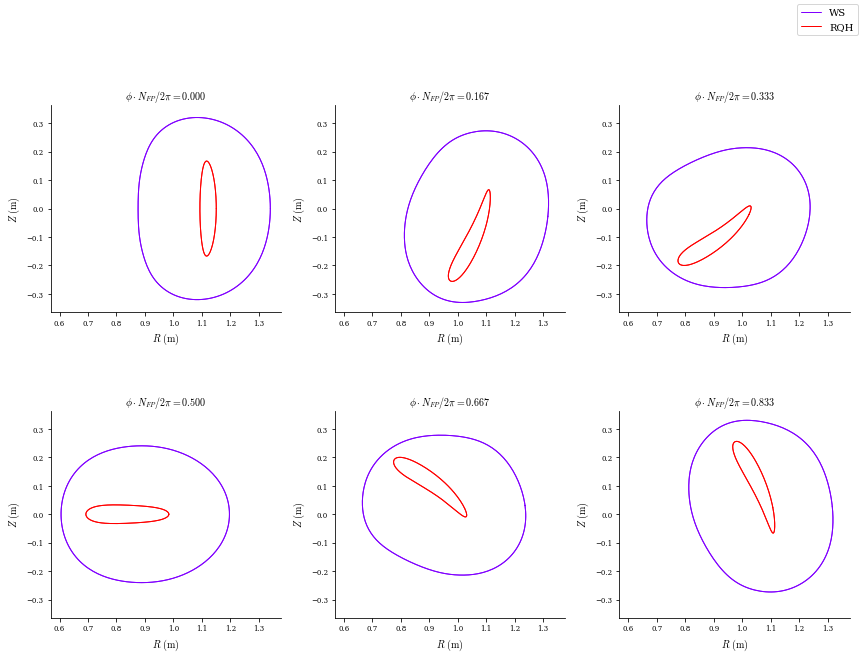

In [4]:
# Plot both surfaces
plot_comparison([surf_winding,eq,],
                labels=["WS","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [5]:
basis_M = 20
basis_N = 20

# Find surface current K_s
surface_current_field = FourierCurrentPotentialField.from_surface(surf_winding,
                                                                  M_Phi=basis_M,
                                                                  N_Phi=basis_N,
                                                                  #sym_Phi = True
                                                                 )


fields, data = solve_regularized_surface_current(  
    surface_current_field,
    eq,
    lambda_regularization=1e-16,
    current_helicity=(1, 1),
    vacuum=True,
    #regularization_type="regcoil",
    eval_grid=LinearGrid(M=50, N=50, NFP=eq.NFP),
    source_grid=LinearGrid(M=70, N=70, NFP=eq.NFP),
    #vc_source_grid=None,
    #external_field=None,
    #external_field_grid=None,
    #verbose=1,
    kappa = -0.7,
)

surface_current_field = fields[0] 

##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-16
##########################################################
chi^2 B = 3.47833e-05
min Bnormal = 2.28052e-19 (T)
Max Bnormal = 3.43900e-06 (T)
Avg Bnormal = 9.54740e-07 (T)
min Bnormal = 2.28879e-19 (unitless)
Max Bnormal = 3.45148e-06 (unitless)
Avg Bnormal = 9.58205e-07 (unitless)


In [6]:
# Save data
np.save('G.npy', surface_current_field.G)
np.save('I.npy', surface_current_field.I)
np.save('phi_mn.npy', surface_current_field.Phi_mn)

/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(


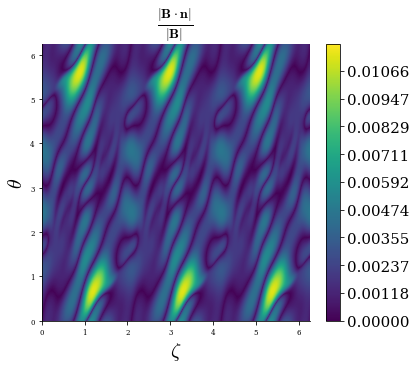

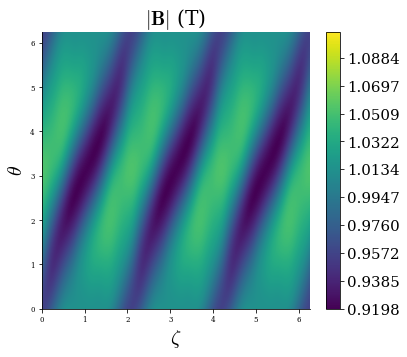

In [7]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surface_current_field.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

plot_figure(Bn,egrid,''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
plot_figure(mag_B,egrid,''r'$|\mathbf{B}|$ (T)')

/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(


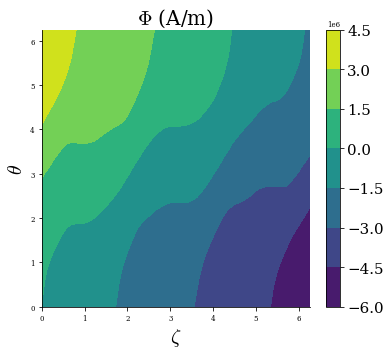

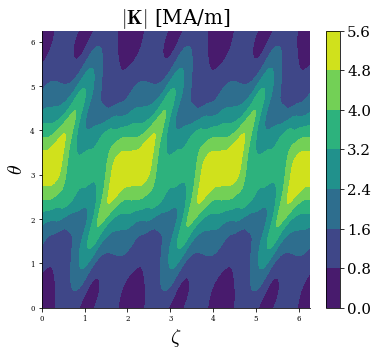

In [8]:
Phi = surface_current_field.compute(["Phi"],grid = egrid)["Phi"]
K_s = surface_current_field.compute(["K"],grid = egrid)["K"]

plot_figure2(Phi,egrid,''r'$\Phi$ (A/m)')
plot_figure2(dot(K_s,K_s)**(1/2)*1e-6,egrid,''r'$|\mathbf{K}|$ [MA/m]')